In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import sys
from pprint import pprint

# sklearn algorithms
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc


# CV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

## functions:

In [2]:
def lab_var_sep(df, labelName):
    '''seperates class from predictor variables: df, columnName -> df, Series'''
    class_labels = df[labelName]
    predictor_variables = df.drop(labelName, axis=1)
    return(class_labels, predictor_variables)

In [3]:
def getEvalStats(predicted, actual):
    '''counts up True/False Positive/Negative results for model evaluation'''
    comp = actual.compare(predicted, keep_equal=True, keep_shape=True) # self = test_y, create comp df
    preds = comp["self"]
    actual = comp["other"]

    TPs = TNs = FPs = FNs = errors = 0
    for i in range(0, len(preds)):
        if (preds[i] == 1): # P
            if (preds[i] == actual[i]): # TP
                TPs += 1
            elif (preds[i] != actual[i]): # FP
                FPs += 1

        elif (preds[i] == 0): # N
            if (preds[i] == actual[i]): # TN
                TNs += 1
            elif (preds[i] != actual[i]): # FN
                FNs += 1
        else:
            errors += 1
            
    if (errors != 0): # returns before giving false information
        print("there was an error somewhere")
        return 0

    return(TPs, TNs, FPs, FNs)

In [4]:
def evaluate(tp, tn, fp, fn):
    '''evaluate the model, returns accuracy, sensitivity, specificity and precision'''
    # accuracy
    accScore = 100 * ( (tn + tp) / (tp + fp + tn + fn) )
    # sensitivity
    senScore = 100 * (tp / (tp + fn) )
    # specificity
    speScore = 100 * (tn / (tn + fp) )
    # precision
    preScore = 100 * (tp / (tp + fp) )

    return(accScore, senScore, speScore, preScore)

In [5]:
def confMatrix(tp, tn, fp, fn):
    '''prints a confusion matrix'''
    cm = pd.DataFrame({"True": [tp, tn], 
                       "False": [fp, fn]
                      }, 
                      index = ["Positive", "Negative"]
                     )
    display(cm)

In [6]:
def dp2(val):
    return (round(val,2))

In [7]:
def printEvalStats(acc, sen, spe, pre):
    '''prints evaluation statistics, returns nothing'''
    print("accuracy:",dp2(acc),"%  ", 
      "sensitivity:",dp2(sen), "%  ", 
      "specificity:",dp2(spe), "%  ",
      "precision:",dp2(pre), "%")

## Task:
As I am working alone I will be using the kNN, Random Forest, and Descision Tree algorithms. 

In [8]:
# loading the files
df_train = pd.read_csv("../CSV_files/creditdefault_train.csv")
df_test = pd.read_csv("../CSV_files/creditdefault_test.csv")

In [9]:
# seperate data into necessary parts
train_y, train_x = lab_var_sep(df_train, "Y") # training
test_y, test_x = lab_var_sep(df_test, "Y") # testing

### Desicion Tree Classifier

Moreover, for each algorithm mentioned above, include at least 1 chart in the notebook illustrating how the performance of the models vary when you vary the hyper parameters’ values.

In [10]:
# gridsearch to find best hyperparameters
scl = StandardScaler()
pca = PCA()
dtc = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('scl', scl),
                       ('pca', pca),
                       ('dtc', dtc)
                      ]
               )

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10]
parameters = dict(dtc__criterion=criterion, 
                  dtc__max_depth=max_depth
                 )

gcv = GridSearchCV(pipe, parameters)
gcv.fit(train_x, train_y)

GridSearchCV(estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dtc', DecisionTreeClassifier())]),
             param_grid={'dtc__criterion': ['gini', 'entropy'],
                         'dtc__max_depth': [2, 4, 6, 8, 10]})

In [11]:
#building a dataframe from cross-validation data
df_cv_scores=pd.DataFrame(gcv.cv_results_).sort_values(by='rank_test_score')

# display top 5 test results
df_cv_scores[
    ['params', 
     'split0_test_score', 
     'split1_test_score', 
     'split2_test_score', 
     'split3_test_score', 
     'split4_test_score', 
     'mean_test_score', 
     'std_test_score', 
     'rank_test_score'
    ] 
].head()

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,"{'dtc__criterion': 'gini', 'dtc__max_depth': 4}",0.789667,0.800667,0.805667,0.821667,0.814667,0.806467,0.011089,1
7,"{'dtc__criterion': 'entropy', 'dtc__max_depth'...",0.789667,0.804000,0.797000,0.822000,0.811333,0.804800,0.011216,2
2,"{'dtc__criterion': 'gini', 'dtc__max_depth': 6}",0.795667,0.800667,0.804333,0.812333,0.810333,0.804667,0.006132,3
8,"{'dtc__criterion': 'entropy', 'dtc__max_depth'...",0.797667,0.805000,0.795000,0.815000,0.808000,0.804133,0.007198,4
6,"{'dtc__criterion': 'entropy', 'dtc__max_depth'...",0.787333,0.802333,0.798667,0.819667,0.810667,0.803733,0.010941,5


In [12]:
# take optimal parameters as variables
bestCri= gcv.best_params_['dtc__criterion']
bestDepth = gcv.best_params_['dtc__max_depth']

print(bestCri)
print(bestDepth)

gini
4


In [13]:
# train the decision tree model using best parameters
dtc = tree.DecisionTreeClassifier(criterion=bestCri, max_depth=bestDepth) # remove the randomness
dtc = dtc.fit(train_x, train_y)

In [14]:
# run the model to obtain predictions and convert to a series
dtcPreds = pd.Series(dtc.predict(test_x))

In [15]:
# Obtain evaluation statistics - true/ false, positive/ negative
tp, tn, fp, fn = getEvalStats(dtcPreds, test_y)

# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

,True,False
Positive,1136,2182
Negative,11123,559


In [16]:
# display evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)
printEvalStats(acc, sen, spe, pre)

accuracy: 81.73 %   sensitivity: 67.02 %   specificity: 83.6 %   precision: 34.24 %


In [17]:
# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, dtcPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

ROC_AUC Value: 
 0.6472617646721917


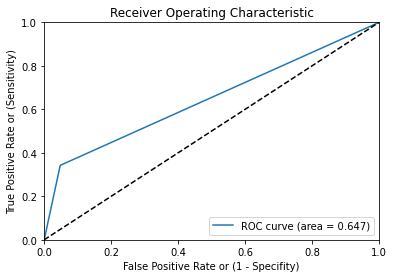

In [18]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation
Here I used gridsearchCV to cross validate my model, which is surprisingly non-precise. I have tried various other hyperparameters and the precision always seems to be very low. The other model parameters are good, and this is only a basic algorithm, so I decided to stop worrying about getting better results.

### Random Forest Classifier

In [19]:
# random search to find best parameters - finally got this down to a reasonable time, but it still takes a while
rfc = RandomForestClassifier() # 

# declare search grid (random grid)
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)] # no. trees
max_features = ['auto', 'sqrt'] # no. features at split
min_samples_split = [10, 20, 40] # min samples to split node
min_samples_leaf = [4, 8, 16] # min leafs required
bootstrap = [True, False] # bootstrap or not

# combine these all into a random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# declare random search
rfc_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 3, 
                               random_state=8, 
                               n_jobs = -1)

# Fit the random search model
rfc_random.fit(train_x, train_y)
pprint(rfc_random.best_params_)

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 40,
 'n_estimators': 120}


In [20]:
# hyerparameter tuning - specific. Still takes a while to run

# declare search grid (tuned grid)
n_estimators = [115, 120, 125] # no. trees
max_features = ['auto', 'sqrt'] # no. features at split
min_samples_split = [30, 40, 50] # min samples to split node
min_samples_leaf = [3, 4, 5] # min leafs required
bootstrap = [True, False] # bootstrap to select samples

# tuned grid
tuned_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
             }

# declare random search
rfc_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = tuned_grid, 
                               n_iter = 20, 
                               cv = 3, 
                               random_state=8, 
                               n_jobs = -1
                               )

# Fit the random search model
rfc_random.fit(train_x, train_y)

nTrees = rfc_random.best_params_["n_estimators"]
mSS = rfc_random.best_params_["min_samples_split"]
mSL = rfc_random.best_params_["min_samples_leaf"]
mF = rfc_random.best_params_["max_features"]
bS = rfc_random.best_params_["bootstrap"]

rfc_random.best_params_

{'n_estimators': 120,
 'min_samples_split': 50,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'bootstrap': True}

In [21]:
#building a dataframe from cross-validation data
df_cv_scores=pd.DataFrame(rfc_random.cv_results_).sort_values(by='rank_test_score')

# displaying the top 5 results
df_cv_scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
10,6.573726,0.173362,0.263424,0.010869,120,50,5,sqrt,True,"{'n_estimators': 120, 'min_samples_split': 50,...",0.8160,0.8272,0.8268,0.823333,0.005188,1
5,7.141542,0.505349,0.315073,0.021477,125,50,3,sqrt,True,"{'n_estimators': 125, 'min_samples_split': 50,...",0.8142,0.8272,0.8276,0.823000,0.006225,2
9,7.389973,0.099044,0.267253,0.005308,125,50,4,auto,True,"{'n_estimators': 125, 'min_samples_split': 50,...",0.8150,0.8260,0.8264,0.822467,0.005282,3
7,7.511269,0.067111,0.267758,0.013141,120,30,3,auto,True,"{'n_estimators': 120, 'min_samples_split': 30,...",0.8128,0.8272,0.8260,0.822000,0.006524,4
19,6.114215,0.415620,0.247900,0.017166,115,50,3,sqrt,True,"{'n_estimators': 115, 'min_samples_split': 50,...",0.8130,0.8264,0.8264,0.821933,0.006317,5


In [22]:
rfc = RandomForestClassifier(n_estimators=nTrees, 
                             min_samples_split=mSS, 
                             min_samples_leaf = mSL, 
                             max_features = mF, 
                             bootstrap = bS, 
                             random_state=8
                            )
rfc = rfc.fit(train_x, train_y)

In [23]:
rfcPreds = pd.Series(rfc.predict(test_x)) # train the model and convert it to a series

In [24]:
# display evaluation statistics, one step further than a 
tp, tn, fp, fn = getEvalStats(rfcPreds, test_y)


# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

,True,False
Positive,1171,2147
Negative,11116,566


In [25]:
# print evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)

printEvalStats(acc, sen, spe, pre)

accuracy: 81.91 %   sensitivity: 67.42 %   specificity: 83.81 %   precision: 35.29 %


In [26]:
# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, rfcPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

ROC_AUC Value: 
 0.6522364200437575


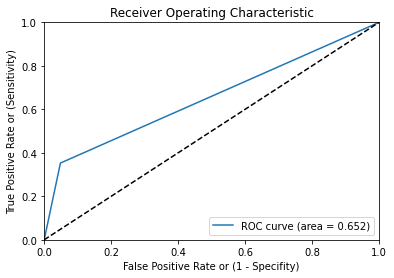

In [29]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation
Using random CV was remarkabely more time consuming than crossgrid CV and gave similar results, however, considering that random forest is much stronger than a basic decision tree, it should likely have performed better. Either there has been some incorrect implementation on my part, randomSearch is a lot worse than gridSearch, or the data doesn't show any clear precision rate regardless of the algorithm used.

### Nearest Neighbour Classifier

In [41]:
# gridsearch to find best hyperparameters
k = int(test_y.size ** (1/2)) # usually provides good k value, so can search around this value

knn = KNeighborsClassifier() # adding k as a parameter her doesn't change the results

weights = ["uniform", "distance"] # weight of nodes to one another
leaf_size = [20, 30, 40]  # used in ballTree or KDTree searches
n_neighbors = [k-40, k-20, k, k+20, k+40] #search around the reccomended k value

parameters = {"weights": weights, 
              "leaf_size": leaf_size, 
              "n_neighbors": n_neighbors 
             }

gcv = GridSearchCV(estimator = knn, 
                   param_grid = parameters, 
                   n_jobs = -1, 
                   cv = 5, 
                  )
gcv.fit(train_x, train_y)

# save results as easier to read variables
weight = gcv.best_params_["weights"]
ls = gcv.best_params_["leaf_size"]
nNs = gcv.best_params_["n_neighbors"]

gcv.best_params_ #display the best parameters

{'leaf_size': 20, 'n_neighbors': 122, 'weights': 'distance'}

In [42]:
#building a dataframe from cross-validation data
df_cv_scores=pd.DataFrame(gcv.cv_results_).sort_values(by='rank_test_score')

# displaying the top 5 results
df_cv_scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.281133,0.024817,1.508696,0.149959,40,122,distance,"{'leaf_size': 40, 'n_neighbors': 122, 'weights...",0.777000,0.779667,0.781667,0.782,0.782667,0.780600,0.002059,1
5,0.235136,0.013410,1.361162,0.118094,20,122,distance,"{'leaf_size': 20, 'n_neighbors': 122, 'weights...",0.777000,0.779667,0.781667,0.782,0.782667,0.780600,0.002059,1
15,0.278728,0.011931,1.513227,0.118124,30,122,distance,"{'leaf_size': 30, 'n_neighbors': 122, 'weights...",0.777000,0.779667,0.781667,0.782,0.782667,0.780600,0.002059,1
27,0.267540,0.017872,1.619642,0.126255,40,142,distance,"{'leaf_size': 40, 'n_neighbors': 142, 'weights...",0.777667,0.779333,0.781333,0.783,0.781333,0.780533,0.001845,4
17,0.324324,0.063239,1.734896,0.221568,30,142,distance,"{'leaf_size': 30, 'n_neighbors': 142, 'weights...",0.777667,0.779333,0.781333,0.783,0.781333,0.780533,0.001845,4


In [43]:
knn = KNeighborsClassifier(n_neighbors=nNs, 
                             weights=weight, 
                             leaf_size=ls, 
                             )
knn = knn.fit(train_x, train_y)

In [44]:
knnPreds = pd.Series(knn.predict(test_x)) # train the model and convert it to a series

In [45]:
# display evaluation statistics, one step further than a 
tp, tn, fp, fn = getEvalStats(knnPreds, test_y)

# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

,True,False
Positive,192,3126
Negative,11506,176


In [46]:
# print evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)

printEvalStats(acc, sen, spe, pre)

accuracy: 77.99 %   sensitivity: 52.17 %   specificity: 78.64 %   precision: 5.79 %


In [47]:
# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, knnPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

ROC_AUC Value: 
 0.5214001355387324


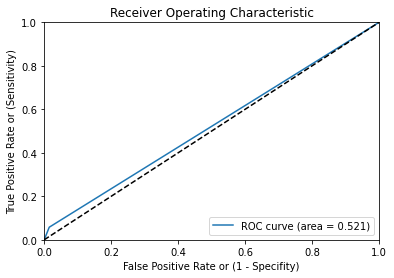

In [48]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation pt1
both the precision and the roc for this model were particularly low so I tried to re-model is using a different range of N estimators

In [52]:
# gridsearch to find best hyperparameters part 2

knn = KNeighborsClassifier() # redeclare empty classifier

weights = ["uniform", "distance"] # weight of nodes to one another
leaf_size = [20, 30, 40] # used in ballTree or KDTree searches
n_neighbors = [5, 9, 13, 17, 21] #search around the reccomended k value

# redeclare new parameters
parameters = {"weights": weights, 
              "leaf_size": leaf_size, 
              "n_neighbors": n_neighbors 
             }

gcv = GridSearchCV(estimator = knn, 
                   param_grid = parameters, 
                   n_jobs = -1, 
                   cv = 5, 
                  )
gcv.fit(train_x, train_y)

# save results as easier to read variables
weight = gcv.best_params_["weights"]
ls = gcv.best_params_["leaf_size"]
nNs = gcv.best_params_["n_neighbors"]

gcv.best_params_ #display the best parameters

{'leaf_size': 20, 'n_neighbors': 21, 'weights': 'uniform'}

In [53]:
knn = KNeighborsClassifier(n_neighbors=nNs, 
                             weights=weight, 
                             leaf_size=ls, 
                             )
knn = knn.fit(train_x, train_y)

knnPreds = pd.Series(knn.predict(test_x)) # train the model and convert it to a series

# display evaluation statistics, one step further than a 
tp, tn, fp, fn = getEvalStats(knnPreds, test_y)

# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

# print evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)

printEvalStats(acc, sen, spe, pre)

# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, knnPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

,True,False
Positive,286,3032
Negative,11326,356


accuracy: 77.41 %   sensitivity: 44.55 %   specificity: 78.88 %   precision: 8.62 %
ROC_AUC Value: 
 0.5278611350269793


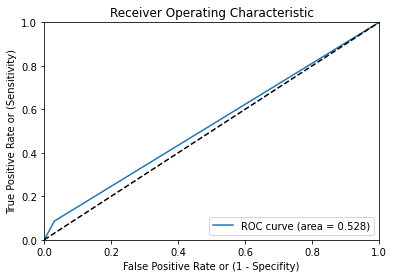

In [54]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation pt. 2
Since this is also a very bad model, I will now run a control

In [55]:
knn = KNeighborsClassifier()
knn = knn.fit(train_x, train_y)
knnPreds = pd.Series(knn.predict(test_x)) # train the model and convert it to a series

# display evaluation statistics, one step further than a 
tp, tn, fp, fn = getEvalStats(knnPreds, test_y)

# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

# print evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)
printEvalStats(acc, sen, spe, pre)

# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, knnPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

,True,False
Positive,612,2706
Negative,10665,1017


accuracy: 75.18 %   sensitivity: 37.57 %   specificity: 79.76 %   precision: 18.44 %
ROC_AUC Value: 
 0.5486957260718256


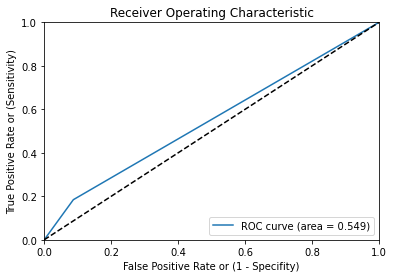

In [56]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation pt 3
A possibility for these outcomes is overfitting, so I will be running the model on the training data to see if it has very high statistics, which would inply overfitting

In [58]:
knn = KNeighborsClassifier()
knn = knn.fit(train_x, train_y)
knnPreds = pd.Series(knn.predict(train_x)) # train the model and convert it to a series

# display evaluation statistics, one step further than a 
tp, tn, fp, fn = getEvalStats(knnPreds, train_y)

# display these as a confusion matrix
confMatrix(tp, tn, fp, fn)

# print evaluation statistics
acc, sen, spe, pre = evaluate(tp, tn, fp, fn)
printEvalStats(acc, sen, spe, pre)

# ROC_AUC value
fpr, tpr, th = roc_curve(test_y, knnPreds)
roc_auc = auc(fpr, tpr)
print("ROC_AUC Value: \n", roc_auc)

,True,False
Positive,1070,2248
Negative,11162,520


accuracy: 81.55 %   sensitivity: 67.3 %   specificity: 83.24 %   precision: 32.25 %
ROC_AUC Value: 
 0.5064418048756173


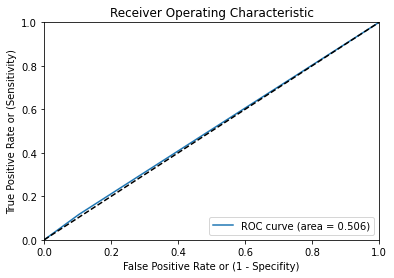

In [59]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Evaluation pt 4
As we can see here, the model definitely does not "overfit". As I was unhappy with the first model I re-trained it with very different n_neighbors values, maintaining the other values in order to isolate whether n_neighbors was an issue; and also with a control classifier. the precision and AUC are both still very low. I have rigorously checked my calculations, as well as having trained it with several different models. The only reasons I can ascertain for this are that either: 
1. I am using the provided Cross Validation algorithms incorrectly
2. The dataset is one which is difficult to train on with these used algorithms  

## Conclusion
Both the random forest and the descision tree models performed much better than the knn one. Within the work I have done, I would choose the descision tree classifier. It trains much faster: Partially because of the type of cross validation used, and because of the computational power needed to run a single tree.  

Overall I am not happy with the models I have trained and I feel like there may be something fundemental that I do not understand about this whole process. I believe my evaluation and process were thorough though, and the attempts to solve the problems I ran into as well as the documentation of said problem solving processes was performed well.  